**📚 6. Project Guidelines**

**Present by:** Paula Rocío Veloza Martínez

**CC:** 1033773200

Programación SIG

Maestría en Geomática

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely

**Reading and Hamornizing Data**

In [2]:
# --- File paths  ---
root_folder=r"/notebooks/060525/Insumos/"

SHAPE_MUN = root_folder+'/municipios_colombia.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'
vias_path = root_folder+'/vias_colombia_V2.shp'


**6.1. Data preparation and CRS**

In [5]:
# Municipalities → GeoDataFrame 
muni = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)
vias = gpd.read_file(vias_path).to_crs(epsg=9377)

# EVA table, rename code column
eva_dt = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva_dt["CULTIVO"] = eva_dt["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
est = pd.read_csv(EST_CSV)
coords = (est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
est["lat"], est["lon"] = coords[0], coords[1]

est = gpd.GeoDataFrame(
    est,
    geometry=gpd.points_from_xy(est["lon"], est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(muni):,} municipalities • {len(est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
muni["MPIO_CCDGO"] = muni["MPIO_CCDGO"].astype(str).str.zfill(5)
eva_dt["cod_mun"] = eva_dt["cod_mun"].astype(str).str.zfill(5)

1,122 municipalities • 8,973 stations • 206,068 EVA rows


In [6]:
eva = eva_dt.rename(columns={'cod_mun': 'MPIO'})
##print(eva.head())

eva['MPIO'] = eva['MPIO'].astype(str).str.zfill(5)
muni['MPIO_CDPMP'] = muni['MPIO_CDPMP'].astype(str).str.zfill(5)

muni_eva = muni.merge(
    eva,
    how='left',                 # left = muni
    left_on='MPIO_CDPMP',       # key in en muni
    right_on='MPIO',            # key in eva
    indicator=True,             # create  column _merge
    validate='one_to_many',      # or 'one_to_many' check all the possibilities
    suffixes=('', '_eva')       # evita colisiones de nombre
)
##print(muni_eva['_merge'].value_counts())
##print(muni_eva.columns.tolist())

print("CRS_Municipios:", muni.crs)   
print("CRS_EVA:", muni_eva.crs)   
print("CRS_Estaciones:", est.crs)   
print("CRS_Vias:", vias.crs)   


CRS_Municipios: EPSG:9377
CRS_EVA: EPSG:9377
CRS_Estaciones: EPSG:9377
CRS_Vias: EPSG:9377


**6.2. Core Analysis steps — Level 1: Municipality selection**

Select an appropriate subset of municipalities relevant to your project (e.g. by department, region, attribute value, or spatial location).

In [7]:
##print(muni_eva.columns.tolist())
cauca=muni_eva[muni_eva["DPTO_CCDGO"].str.upper().str.contains("19")].copy()
cauca.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,AÑO,PERIODO,Área Sembrada\n(ha),Área Cosechada\n(ha),Producción\n(t),Rendimiento\n(t/ha),ESTADO FISICO PRODUCCION,NOMBRE \nCIENTIFICO,CICLO DE CULTIVO,_merge
2344,19,00001,POPAYÁN,19001,2018,4.801797e+08,2.471704,-76.591944,129302.0,504.0,...,2008.0,2008,10.0,0.0,0.0,NaN,FRUTO FRESCO,PERSEA AMERICANA MILL.,PERMANENTE,both
2345,19,00001,POPAYÁN,19001,2018,4.801797e+08,2.471704,-76.591944,129302.0,504.0,...,2009.0,2009,18.0,0.0,0.0,NaN,FRUTO FRESCO,PERSEA AMERICANA MILL.,PERMANENTE,both
2346,19,00001,POPAYÁN,19001,2018,4.801797e+08,2.471704,-76.591944,129302.0,504.0,...,2010.0,2010,25.0,10.0,110.0,11.0,FRUTO FRESCO,PERSEA AMERICANA MILL.,PERMANENTE,both
2347,19,00001,POPAYÁN,19001,2018,4.801797e+08,2.471704,-76.591944,129302.0,504.0,...,2011.0,2011,25.0,10.0,110.0,11.0,FRUTO FRESCO,PERSEA AMERICANA MILL.,PERMANENTE,both
2348,19,00001,POPAYÁN,19001,2018,4.801797e+08,2.471704,-76.591944,129302.0,504.0,...,2012.0,2012,25.0,25.0,275.0,11.0,FRUTO FRESCO,PERSEA AMERICANA MILL.,PERMANENTE,both


- Compute one or more spatial buffers where appropriate (e.g. buffers around roads to assess accessibility).
- Use topological relations (intersects, within, contains, touches) as needed to evaluate relationships between layers.

In [8]:
##Intersect Vias with Cauca Department

cauca_vias_bool = vias.intersects(cauca.geometry.iloc[0])
cauca_vias_bool # Display the boolean dataset

0         False
1         False
2         False
3         False
4         False
          ...  
108223    False
108224    False
108225    False
108226    False
108227    False
Length: 108228, dtype: bool

In [9]:
cauca_vias = vias[cauca_vias_bool]
##print(cauca_vias)

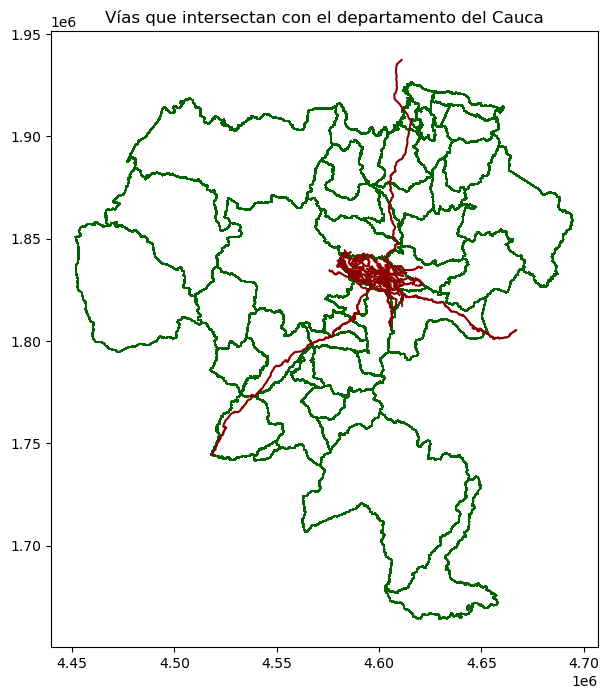

In [10]:
ax = cauca.plot(color="none", edgecolor="darkgreen", figsize=(8, 8))
cauca_vias.plot(ax=ax, color="darkred", markersize=0.8)
plt.title("Vías que intersectan con el departamento del Cauca")
plt.show()

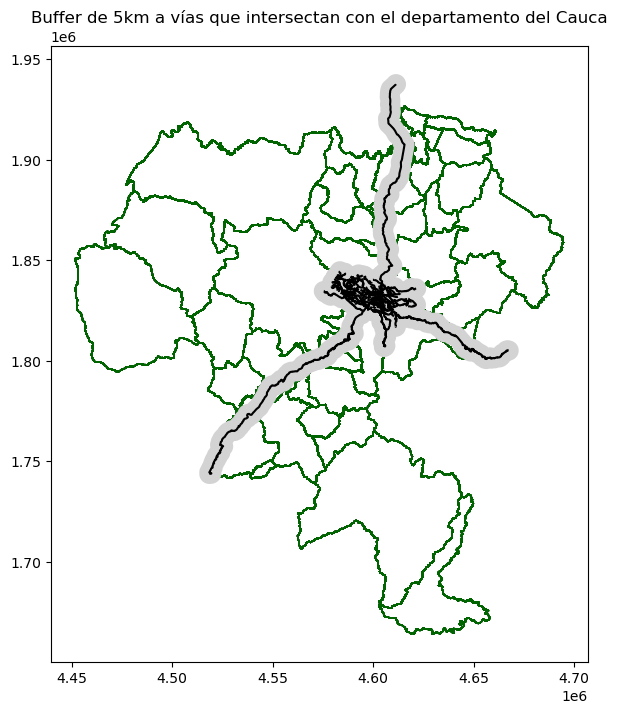

In [11]:
##Buffer arround Vias in Cauca

# 1. Create a 5 km buffer around vias in Cauca
vias_cauca_buffer = cauca_vias.copy()
vias_cauca_buffer["geometry_5km"] = vias_cauca_buffer.geometry.buffer(5000)
vias_cauca_buffer = vias_cauca_buffer.set_geometry("geometry_5km")

# 2. Plot
ax = cauca.plot(color="none", edgecolor="darkgreen", figsize=(8, 8))
cauca_vias.plot(ax=ax, color="black", markersize=0.8)
vias_cauca_buffer.plot(ax=ax, color="lightgrey", markersize=2)
plt.title("Buffer de 5km a vías que intersectan con el departamento del Cauca")
plt.show()



- Perform at least one type of spatial join.

In [12]:
# 1. Spatial join: each station takes the attributes of the municipality it falls in

##print(vias_cauca_buffer.head())


muni_in_buffer_vias = gpd.sjoin(
    vias_cauca_buffer,                     # left: point layer
    muni[["MPIO_CCDGO", "MPIO_CNMBR", "geometry"]],  # right: polygon layer
    how="left",
    predicate="intersects"           # point inside polygon
)

# 2. Inspect the result
muni_in_buffer_vias[["TIPO_VIA","MPIO_CNMBR", "MPIO_CCDGO"]].head()

,TIPO_VIA,MPIO_CNMBR,MPIO_CCDGO
65788,6,PURACÉ,00585
65788,6,POPAYÁN,00001
65792,5,POPAYÁN,00001
65795,5,POPAYÁN,00001
65795,5,TOTORÓ,00824


Include at least one example of joining incongruent layers:
- For example: compute road density per municipality by performing an overlay between the road network and municipality polygons (e.g. length of roads per km² of municipality area).
- Other options: interpolate EVA production onto a grid and aggregate to municipalities

In [13]:
cauca_vias_clip = gpd.overlay(cauca_vias, cauca, how='intersection')
cauca_vias_clip["longitud_m"] = cauca_vias_clip.geometry.length

long_por_mpio = cauca_vias_clip.groupby("MPIO_CCDGO")["longitud_m"].sum().reset_index()
long_por_mpio.rename(columns={"longitud_m": "longitud_total_m"}, inplace=True)

cauca["area_km2"] = cauca.geometry.area / 1e6  # m² a km²
cauca = cauca.merge(long_por_mpio, on="MPIO_CCDGO", how="left")
cauca["densidad_vial_km_km2"] = (cauca["longitud_total_m"] / 1000) / cauca["area_km2"]


In [14]:
densidad_vias_cauca=cauca.drop_duplicates(subset=['MPIO_CCDGO']).copy()
##densidad_vias_cauca
densidad_vias_cauca = densidad_vias_cauca.sort_values(by="densidad_vial_km_km2", ascending=False)
densidad_vias_cauca[["MPIO_CCDGO", "MPIO_CNMBR", "DEPARTAMENTO", "area_km2", "longitud_total_m", "densidad_vial_km_km2"]].head(40)

,MPIO_CCDGO,MPIO_CNMBR,DEPARTAMENTO,area_km2,longitud_total_m,densidad_vial_km_km2
0,00001,POPAYÁN,CAUCA,480.379241,1.193485e+08,248.446334
6763,00807,TIMBÍO,CAUCA,201.392195,7.845652e+06,38.957082
8127,00845,VILLA RICA,CAUCA,81.648450,2.966039e+06,36.326951
5097,00622,ROSAS,CAUCA,169.180130,4.043250e+06,23.899084
6089,00760,SOTARÁ - PAISPAMBA,CAUCA,516.165567,1.164739e+07,22.565227
4262,00532,PATÍA,CAUCA,755.838766,1.518230e+07,20.086695
3146,00450,MERCADERES,CAUCA,698.545016,1.296589e+07,18.561277
4644,00548,PIENDAMÓ - TUNÍA,CAUCA,181.341533,3.148563e+06,17.362613
7292,00824,TOTORÓ,CAUCA,404.584546,5.701301e+06,14.091741
4961,00585,PURACÉ,CAUCA,848.552295,1.100368e+07,12.967591


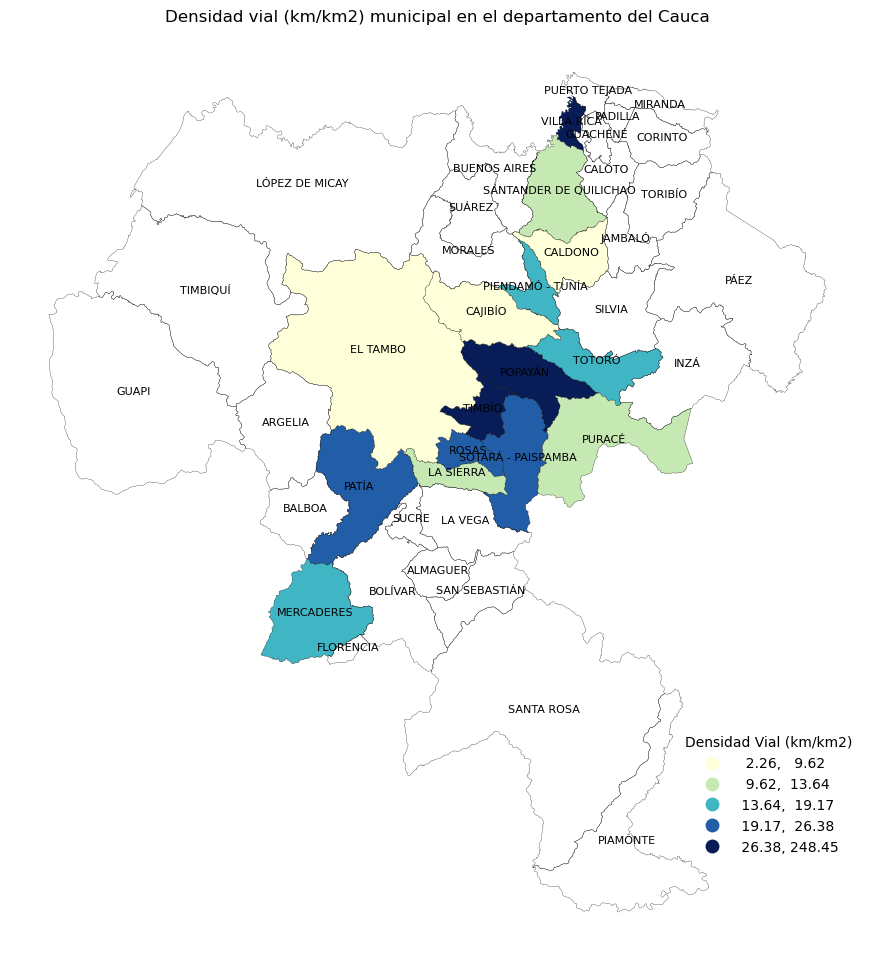

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Mapa principal (municipios con datos)
densidad_vias_cauca.dropna(subset=['densidad_vial_km_km2']).plot(
    column='densidad_vial_km_km2',
    scheme='Quantiles', k=5,
    cmap='YlGnBu', legend=True,
    ax=ax,
    edgecolor='black', linewidth=0.2
)

# Municipios sin datos (NaN)
densidad_vias_cauca[densidad_vias_cauca['densidad_vial_km_km2'].isna()].plot(
    color='none', ax=ax,
    edgecolor='black', linewidth=0.2
)
ax.set_title(f'Densidad vial (km/km2) municipal en el departamento del Cauca')
ax.set_axis_off()
ax.set_axis_off()
for idx, row in densidad_vias_cauca.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['MPIO_CNMBR'], xy=(centroid.x, centroid.y), xytext=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=8)

# Mover la leyenda por defecto debajo del mapa
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.25))  # x centrado (0.5), y por debajo (-0.15)
leg.set_title("Densidad Vial (km/km2)")       # título de la leyenda (opcional)
leg.set_frame_on(False)               # sin borde (opcional)

plt.show()

Apply at least one geometry operation to refine your analysis:
- Affine transformation (rotate, scale, translate — can be used for illustration or testing).
- Intersection, union, or difference of polygons to model or visualise candidate areas.
- Clipping vs sub-setting should be demonstrated in at least one part of your workflow.

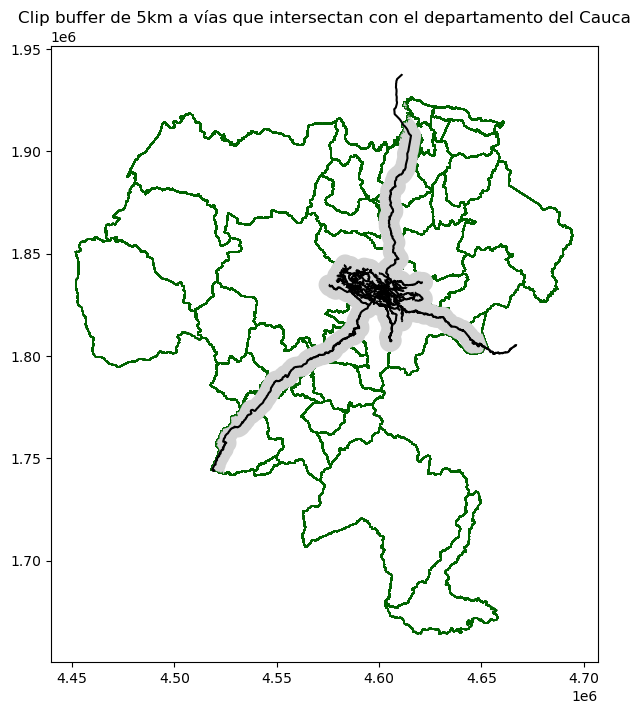

In [16]:
buffer_vias_cauca_clip = gpd.clip(vias_cauca_buffer, cauca)

ax = cauca.plot(color="none", edgecolor="darkgreen", figsize=(8, 8))
cauca_vias.plot(ax=ax, color="black", markersize=0.8)
buffer_vias_cauca_clip.plot(ax=ax, color="lightgrey", markersize=2)
plt.title("Clip buffer de 5km a vías que intersectan con el departamento del Cauca")
plt.show()

**6.3 Multi-criteria analysis — Level 1**

Once you have selected your best municipality, you will conduct a second level of spatial analysis to identify the best local area within that municipality.

In [202]:
##First Criteria: Densidad vial por municipio
densidad_vias_cauca[["MPIO_CCDGO", "MPIO_CNMBR", "DEPARTAMENTO", "area_km2", "longitud_total_m", "densidad_vial_km_km2"]].sort_values('densidad_vial_km_km2', ascending=False).head(16)

,MPIO_CCDGO,MPIO_CNMBR,DEPARTAMENTO,area_km2,longitud_total_m,densidad_vial_km_km2
0,00001,POPAYÁN,CAUCA,480.379241,1.193485e+08,248.446334
6763,00807,TIMBÍO,CAUCA,201.392195,7.845652e+06,38.957082
8127,00845,VILLA RICA,CAUCA,81.648450,2.966039e+06,36.326951
5097,00622,ROSAS,CAUCA,169.180130,4.043250e+06,23.899084
6089,00760,SOTARÁ - PAISPAMBA,CAUCA,516.165567,1.164739e+07,22.565227
4262,00532,PATÍA,CAUCA,755.838766,1.518230e+07,20.086695
3146,00450,MERCADERES,CAUCA,698.545016,1.296589e+07,18.561277
4644,00548,PIENDAMÓ - TUNÍA,CAUCA,181.341533,3.148563e+06,17.362613
7292,00824,TOTORÓ,CAUCA,404.584546,5.701301e+06,14.091741
4961,00585,PURACÉ,CAUCA,848.552295,1.100368e+07,12.967591


In [19]:
cauca_nd = cauca.drop_duplicates(subset=['MPIO_CNMBR']).copy()

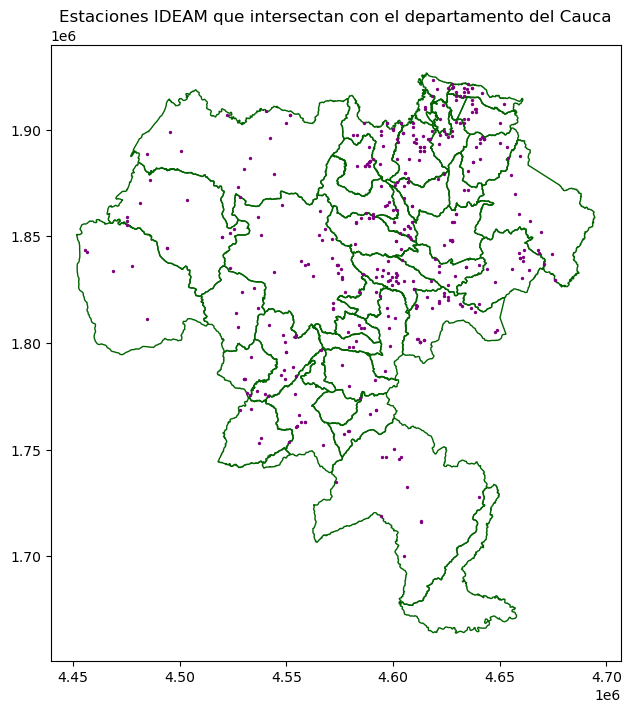

In [20]:
##Second Criteria: numero de estaciones por municipio
cauca_est = gpd.overlay(est, cauca_nd, how='intersection').copy()

ax = cauca_nd.plot(color="none", edgecolor="darkgreen", figsize=(8, 8))
cauca_est.plot(ax=ax, color="purple", markersize=2)
plt.title("Estaciones IDEAM que intersectan con el departamento del Cauca")
plt.show()

In [21]:
est_por_mpio = cauca_est.groupby("MPIO_CNMBR")["MPIO_CNMBR"].count().sort_values(ascending=False).copy()
est_por_mpio = est_por_mpio.reset_index(name='Conteo')
print(est_por_mpio.head(42))

                MPIO_CNMBR  Conteo
0                 EL TAMBO      31
1   SANTANDER DE QUILICHAO      28
2                   PURACÉ      25
3                  POPAYÁN      21
4                  MIRANDA      17
5             BUENOS AIRES      15
6                    PATÍA      15
7                  TORIBÍO      14
8           LÓPEZ DE MICAY      13
9                     INZÁ      12
10                    PÁEZ      12
11                  SUÁREZ      12
12              SANTA ROSA      12
13                 CAJIBÍO      11
14                TIMBIQUÍ      11
15        PIENDAMÓ - TUNÍA      11
16                 CORINTO      10
17                 CALDONO      10
18                  SILVIA      10
19                  CALOTO       9
20                 BOLÍVAR       9
21                  TOTORÓ       8
22      SOTARÁ - PAISPAMBA       7
23                 MORALES       7
24                   GUAPI       6
25                  BALBOA       6
26           SAN SEBASTIÁN       6
27                 A

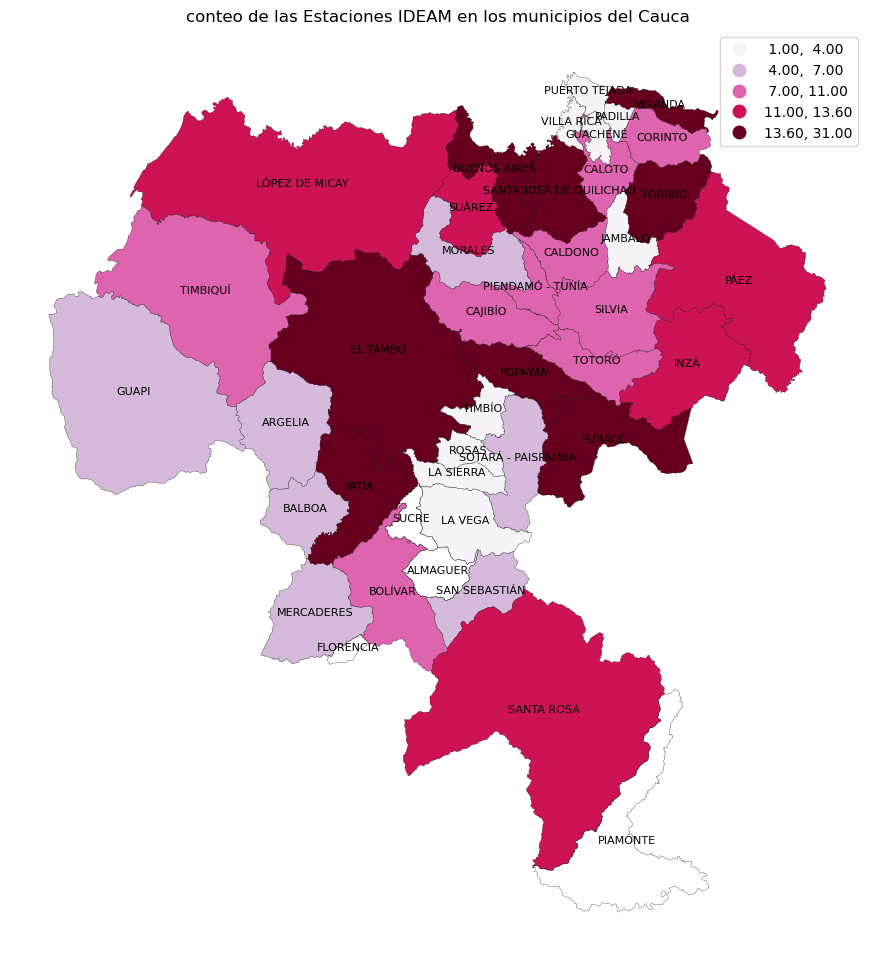

In [22]:
est_cauca = cauca_nd.merge(
    est_por_mpio,
    how='left',                 # left = muni
    left_on='MPIO_CNMBR',       # key in en muni
    right_on='MPIO_CNMBR',            # key in eva
    validate='many_to_many',      # or 'one_to_many' check all the possibilities
    suffixes=('', '_stat')       # evita colisiones de nombre
)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Mapa principal (municipios con datos)
est_cauca.dropna(subset=['Conteo']).plot(
    column='Conteo',
    scheme='Quantiles', k=5,
    cmap='PuRd', legend=True,
    ax=ax,
    edgecolor='black', linewidth=0.2
)

# Municipios sin datos (NaN)
est_cauca[est_cauca['Conteo'].isna()].plot(
    color='none', ax=ax,
    edgecolor='black', linewidth=0.2
)
ax.set_axis_off()
for idx, row in densidad_vias_cauca.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['MPIO_CNMBR'], xy=(centroid.x, centroid.y), xytext=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=8)


ax.set_title(f'conteo de las Estaciones IDEAM en los municipios del Cauca')
ax.set_axis_off()
plt.show()


                  MPIO_CNMBR  dist_mas_cercana_km
8127              VILLA RICA             0.246740
868                  BOLÍVAR             0.571477
6392                  SUÁREZ             0.607129
4790           PUERTO TEJADA             0.620912
0                    POPAYÁN             1.055407
4262                   PATÍA             1.256611
1676                  CALOTO             1.482796
2223                GUACHENÉ             1.490781
7292                  TOTORÓ             1.721777
6089      SOTARÁ - PAISPAMBA             1.983598
377                  ARGELIA             2.044313
3437                 MIRANDA             2.052878
5097                   ROSAS             2.117647
7485                EL TAMBO             2.120021
2532                 JAMBALÓ             2.211900
2827               LA SIERRA             2.307411
5414  SANTANDER DE QUILICHAO             2.428011
3879                 PADILLA             2.449348
5750                  SILVIA             2.951046


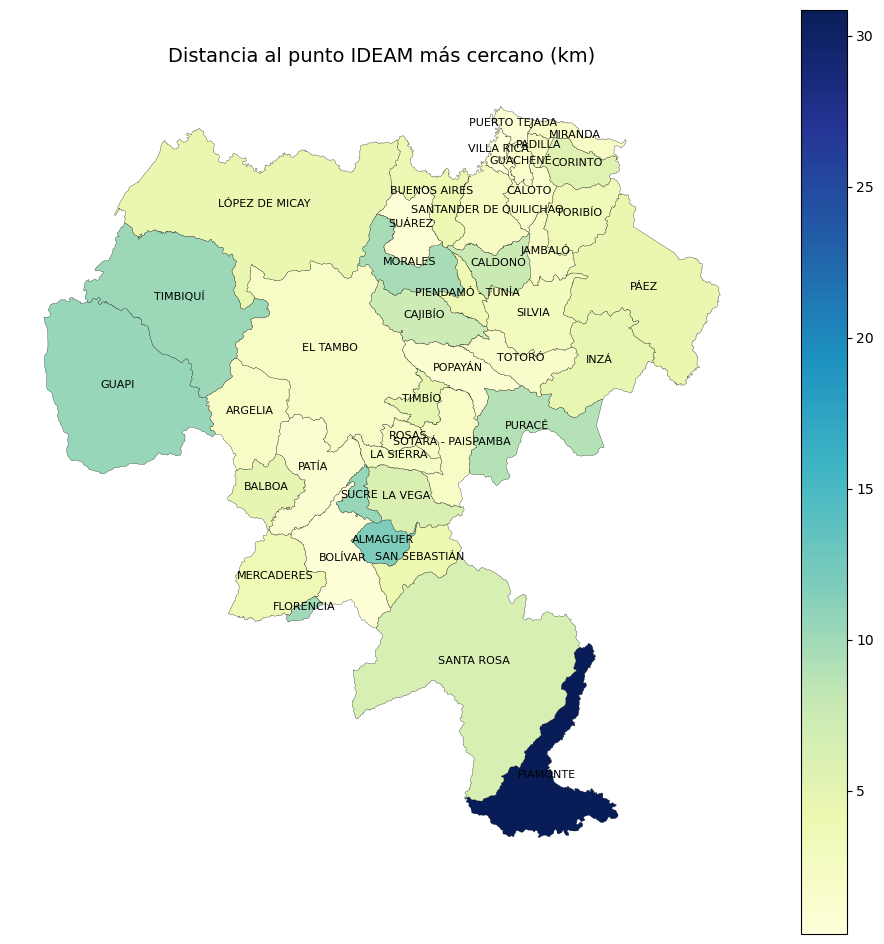

In [23]:
##Third Criteria: distancia a estaciones

from shapely.ops import nearest_points

# Unir todas las estaciones IDEAM en una sola geometría (MultiPoint)
est_union = cauca_est.union_all()

# Función para hallar la distancia desde el centroide del municipio al punto IDEAM más cercano
def distancia_mas_cercana(geom):
    punto_municipio = geom.centroid
    punto_cercano = nearest_points(punto_municipio, est_union)[1]
    return punto_municipio.distance(punto_cercano)

# Calcular distancia en metros y luego convertir a kilómetros
cauca_nd['dist_mas_cercana_m'] = cauca_nd.geometry.apply(distancia_mas_cercana)
cauca_nd['dist_mas_cercana_km'] = cauca_nd['dist_mas_cercana_m'] / 1000

# Mostrar los 10 municipios más alejados de una estación IDEAM
print(cauca_nd[['MPIO_CNMBR', 'dist_mas_cercana_km']].sort_values('dist_mas_cercana_km', ascending=True).head(42))

# Mapa: distancia al punto IDEAM más cercano
ax = cauca_nd.plot(
    column='dist_mas_cercana_km',
    cmap='YlGnBu',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    figsize=(12, 12)
)
ax.set_title('Distancia al punto IDEAM más cercano (km)', fontsize=14)
ax.set_axis_off()
for idx, row in densidad_vias_cauca.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['MPIO_CNMBR'], xy=(centroid.x, centroid.y), xytext=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=8)

plt.show()



In [24]:
##Fourth Criteria: Producción por municipio de Quinua
# --- Parameters -------------------------------------------------------------
selected_year = '2018A'          # <- choose the year you want to visualise
crop_name     = 'FRIJOL'       # <- crop label exactly as it appears in EVA

# --- Subset for crop and year ----------------------------------------------
frijol = (
    cauca
    .query("CULTIVO == @crop_name and PERIODO == @selected_year")  # edit column name if needed
    .copy()
)

frijol['yield_t_ha'] = (
    frijol['Producción\n(t)'] / frijol['Área Sembrada\n(ha)']
)

print(frijol[['MPIO_CNMBR', 'CULTIVO', 'Producción\n(t)', 'Área Sembrada\n(ha)', 'yield_t_ha']].sort_values('yield_t_ha', ascending=False).head(42))


                  MPIO_CNMBR CULTIVO  Producción\n(t)  Área Sembrada\n(ha)  \
3575                 MIRANDA  FRIJOL             49.0                 21.0   
6649                   SUCRE  FRIJOL             34.0                 15.0   
4186                    PÁEZ  FRIJOL           1888.0                900.0   
7093                 TORIBÍO  FRIJOL              6.0                  3.0   
6461                  SUÁREZ  FRIJOL             76.0                 42.0   
1467                 CAJIBÍO  FRIJOL            175.0                100.0   
7383                  TOTORÓ  FRIJOL             78.0                 46.0   
8201              VILLA RICA  FRIJOL              5.0                  3.0   
4725        PIENDAMÓ - TUNÍA  FRIJOL             31.0                 20.0   
479                  ARGELIA  FRIJOL             14.0                 10.0   
259                 ALMAGUER  FRIJOL             42.0                 30.0   
256                 ALMAGUER  FRIJOL             42.0           

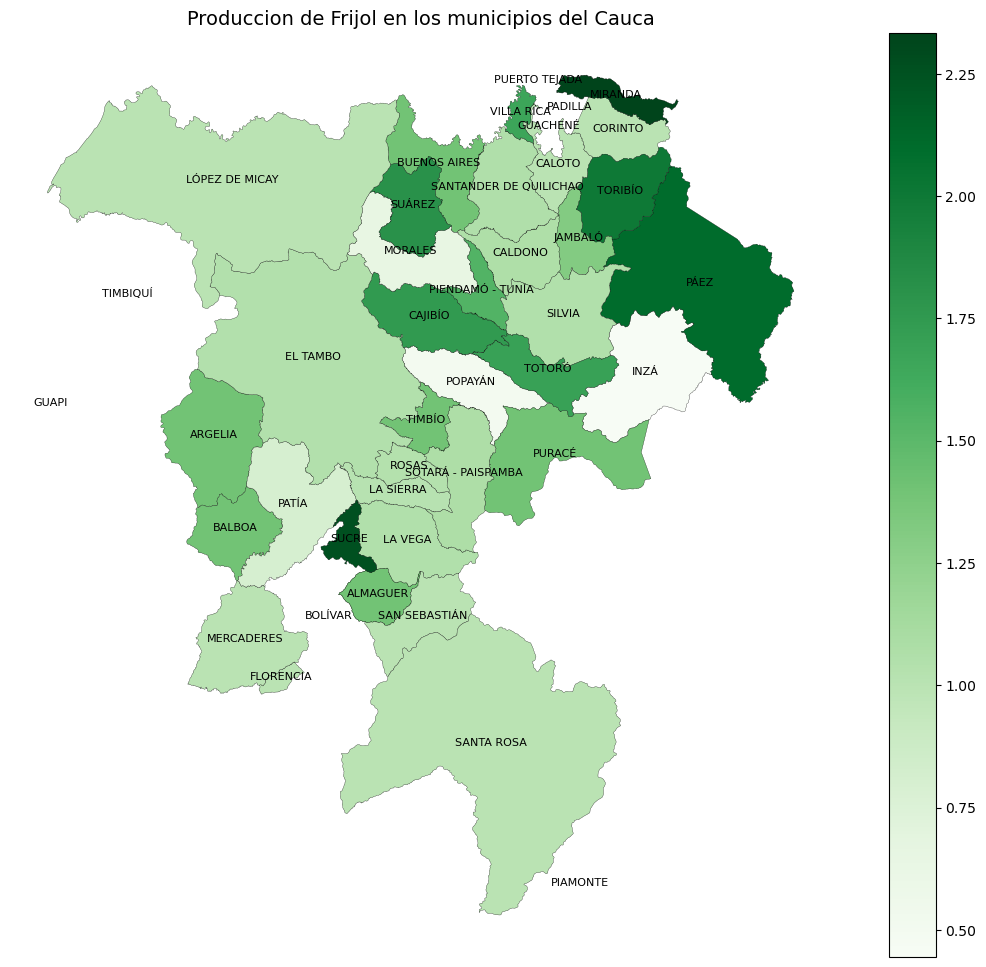

In [25]:
# Mapa: distancia al punto IDEAM más cercano
ax = frijol.plot(
    column='yield_t_ha',
    cmap='Greens',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    figsize=(15, 12)
)

ax.set_title('Produccion de Frijol en los municipios del Cauca', fontsize=14)
ax.set_axis_off()
for idx, row in densidad_vias_cauca.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['MPIO_CNMBR'], xy=(centroid.x, centroid.y), xytext=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=8)

plt.show()



**6.4 Core analysis steps — Level 2: Best location within selected municipality**

Once you have selected your best municipality, you will conduct a second level of spatial analysis to identify the best local area within that municipality.

**Municipio seleccionado:** Villa Rica

In [26]:
import numpy as np
import shapely

villa_rica = cauca[cauca['MPIO_CNMBR'] == 'VILLA RICA']


# Create a regular grid covering Villa Rica

# Bounds of the municipalities layer
bounds = villa_rica.total_bounds
xmin, ymin, xmax, ymax = bounds

# Define grid resolution (example: 5 km x 5 km grid → 100_000 m)
res = 5000

# Build grid coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()

# Build polygons for each grid cell
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([
                (x, y),
                (x + res, y),
                (x + res, y - res),
                (x, y - res)
            ])
        )

# Create grid GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=villa_rica.crs)

# Remove cells that fall outside the total extent (intersect municipalities only)
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]

# Add unique ID
grid['id'] = grid.index

grid.head()

,geometry,id
0,"POLYGON ((4610149 1921630, 4615149 1921630, 46...",0
1,"POLYGON ((4610149 1916630, 4615149 1916630, 46...",1
2,"POLYGON ((4610149 1911630, 4615149 1911630, 46...",2
3,"POLYGON ((4610149 1906630, 4615149 1906630, 46...",3
5,"POLYGON ((4615149 1921630, 4620149 1921630, 46...",5


In [27]:
# Vías dentro de Villa Rica
vias_vr = vias[vias.intersects(villa_rica.union_all())]

# Distancia mínima por celda
grid['dist_vias'] = grid.geometry.centroid.apply(
    lambda x: vias_vr.distance(x).min()
)

In [28]:
# Distancia estaciones

estaciones_vr = est[est.within(villa_rica.union_all())]

grid['dist_estaciones'] = grid.geometry.centroid.apply(
    lambda x: estaciones_vr.distance(x).min()
)

In [36]:
cob_path = root_folder+'/cobertura_vr.shp'
cob = gpd.read_file(cob_path).to_crs(epsg=9377)
cob.columns.tolist()

zonas_prod = cob[cob['nivel_1'] == '2']
grid['zonas_prod'] = grid.geometry.intersects(zonas_prod.union_all()).astype(int)

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
grid[['dist_vias_n', 'dist_estaciones_n']] = scaler.fit_transform(
    grid[['dist_vias', 'dist_estaciones']]
)

# Invertimos porque queremos menor distancia = mayor preferencia
grid['score'] = (
    (1 - grid['dist_vias_n']) * 0.4 + 
    (1 - grid['dist_estaciones_n']) * 0.4 + 
    (1 - grid['zonas_prod']) * 0.2
)

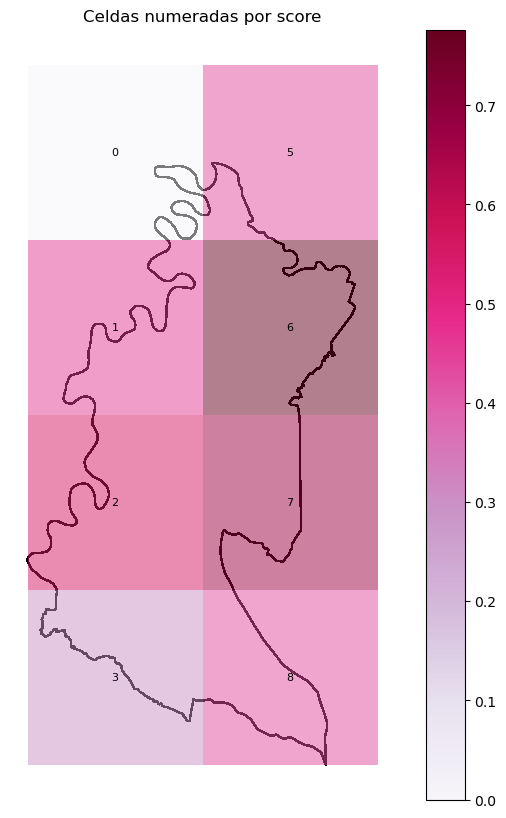

In [46]:
import matplotlib.pyplot as plt

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8, 10))

# Plotear municipio
villa_rica.plot(ax=ax, edgecolor='black', facecolor='none')

# Plotear grid coloreado por 'score'
grid.plot(ax=ax, column='score', cmap='PuRd', legend=True, alpha=0.5)

# Añadir etiquetas numéricas en cada celda del grid
for idx, row in grid.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(idx), color='black', fontsize=8, ha='center', va='center')

# Título y ejes
ax.set_title('Celdas numeradas por score')
ax.set_axis_off()
plt.show()




**De acuerdo con lo anterior, la zona que presenta mejores resultados es la zona 6 del municipio de Villa Rica.**